# Make the Notebook run in IBM Watson

In [1]:
# The code was removed by Watson Studio for sharing.

In [2]:
# START CODE BLOCK
# cos2file - takes an object from Cloud Object Storage and writes it to file on container file system.
# Uses the IBM project_lib library.
# See https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/project-lib-python.html
# Arguments:
# p: project object defined in project token
# data_path: the directory to write the file
# filename: name of the file in COS

import os
def cos2file(p,data_path,filename):
    data_dir = p.project_context.home + data_path
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    open( data_dir + '/' + filename, 'wb').write(p.get_file(filename).read())

# file2cos - takes file on container file system and writes it to an object in Cloud Object Storage.
# Uses the IBM project_lib library.
# See https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/project-lib-python.html
# Arguments:
# p: prooject object defined in project token
# data_path: the directory to read the file from
# filename: name of the file on container file system

import os
def file2cos(p,data_path,filename):
    data_dir = p.project_context.home + data_path
    path_to_file = data_dir + '/' + filename
    if os.path.exists(path_to_file):
        file_object = open(path_to_file, 'rb')
        p.save_data(filename, file_object, set_project_asset=True, overwrite=True)
    else:
        print("file2cos error: File not found")
# END CODE BLOCK

In [3]:
cos2file(project, '/data', 'aavail-target.csv')

# Decision Trees

Decision trees are a simple, intuitive approach to regression and classification. As long as the trees are reasonably sized, they are easy to interpret and visualize, which means that they can serve as an important communication tool. For example, if we wanted a very interpretable model, we could use a decision tree to first partition our data. Then we could use different models for each leaf node. Let's see how a simple decision tree does with the AAVAIL customer retention data.

In [4]:
#!pip install -U scikit-learn

In [5]:
import sys
import os
import re
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.pipeline import Pipeline

In [6]:
from sklearn import __version__
__version__

'0.22.2.post1'

In [7]:
def load_data():

    data_dir = os.path.join("..","data")
    df = pd.read_csv(os.path.join(data_dir,r"aavail-target.csv"))

    ## pull out the target and remove uneeded columns
    _y = df.pop('is_subscriber')
    y = np.zeros(_y.size)
    y[_y==0] = 1 
    df.drop(columns=['customer_id','customer_name'],inplace=True)
    return(y,df)

In [8]:
## variables
rs = 42

## preprocessing pipeline
numeric_features = ['age', 'num_streams']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_features = ['country', 'subscriber_type']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [9]:
## load the data
y, df = load_data()
X_train, X_test, y_train, y_test = train_test_split(df, y,
                                                    test_size=0.2, stratify=y, random_state=rs)

In [10]:
pipe  = Pipeline(steps=[('preprocessor', preprocessor),
                        ('dt', DecisionTreeClassifier(min_samples_leaf=100))])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

In [11]:
 ## extract feature names 
feature_names = np.hstack([numeric_features,
                           preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names()])

feature_names = [re.sub("x\d_","",fn) for fn in feature_names]
target_names = ['subscriber','churned']
print(feature_names)
print(classification_report(y_test, y_pred, target_names=target_names))

['age', 'num_streams', 'singapore', 'united_states', 'aavail_basic', 'aavail_premium', 'aavail_unlimited']
              precision    recall  f1-score   support

  subscriber       0.83      0.91      0.87       142
     churned       0.71      0.55      0.62        58

    accuracy                           0.81       200
   macro avg       0.77      0.73      0.75       200
weighted avg       0.80      0.81      0.80       200



In [12]:
!pip install graphviz

In [13]:
def create_images_dir(p, images_path):
    images_dir = p.project_context.home + images_path
    if not os.path.exists(images_dir):
        print("...create images directory")
        os.makedirs(images_dir)
    else:
        print("...images directory exists")
        
create_images_dir(project, "/images")

...images directory exists


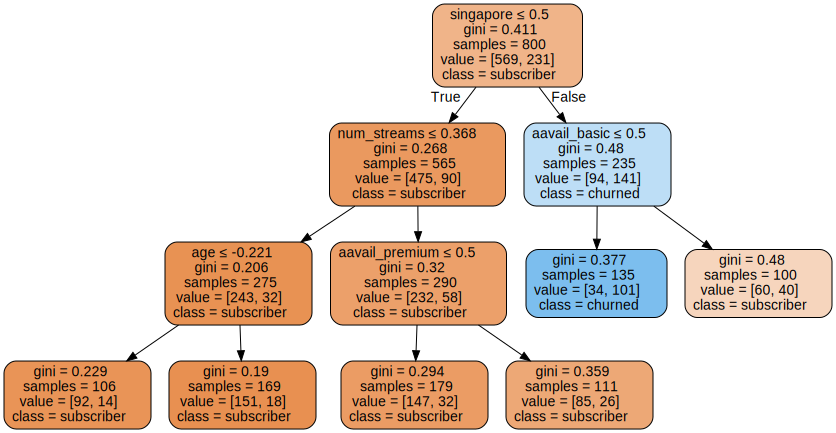

In [14]:
## make plot
try:
    import graphviz        
except:
    print("not creating tree since graphviz is not installed")
    sys.exit()
    
from graphviz import Source
from sklearn.tree import export_graphviz
    
image_dir = os.path.join("..","images")
    
dot_data = export_graphviz(pipe['dt'], 
                           out_file=os.path.join(image_dir, "iris_tree.dot"), feature_names=feature_names,  
                           class_names=target_names,  filled=True, rounded=True,  
                           special_characters=True)

Source.from_file(os.path.join(image_dir, "iris_tree.dot"))

It actually does reasonably well considering the simplicity of the model. Even if this is not a model that would go into production it could be used to inform strategic decision making. Notice how the model naturally identifies the largest subgroup of churned subscribers with only two splits.

In the script above we used `min_sampled_leaf` to prevent the tree from overfitting. The `DecisionTreeClassifier` provides other parameters such as the `max_depth` that can be used. Cost complexity pruning provides another option to control the size of the tree.

# Bagging

Before we get to random forests, it makes sense to talk about bagging or bootstrap aggregating since random forests are essentially an extension of this idea. Recall that bootstraping is generally used to estimate the confidence around an estimate (or really any statistic).

In [15]:
import numpy as np
x = np.random.normal(50.0, 10.0, 100)
nsamples = 500
bs_samples = np.random.choice(x, (nsamples, x.size), replace=True)
bs_distn = np.mean(bs_samples, axis=1)
print("Bootstrap CI: (%.4f, %.4f)"%(bs_distn[int(0.025*nsamples)], bs_distn[int(0.975*nsamples)]))

Bootstrap CI: (50.5806, 50.0908)


Bootstraping can also be used to help make the estimate, which is exactly what was proposed in the context of decision trees. The individual trees, each with its own bootstrap sample are grown large and because decision trees are naturally high variance models the ensemble itself is high variance. That variance is then reduced by an averaging step. The trees themselves are correlated and because each bootstrap sample is a subsample of the original these correlations contribute to the variance component error. The random forest method was proposed then, which includes the additonal mechanic of randomly subsetting the features to choose from at each decision to split. This helps decorrelate the trees and accordingly reduce the variance.

In this example we are creating bagging ensembles for three different types of base models each being built on random subsets of 50% of the samples and 50% of the features.

In [16]:
import numpy as np
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

np.random.seed(0)
iris = load_iris()
X, y = iris.data, iris.target
indices = np.arange(y.shape[0])
np.random.shuffle(indices)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

bm_name = ["KNN", "DT", "SVM"]
for bm, basemodel in enumerate([KNeighborsClassifier(), DecisionTreeClassifier(), SVC(kernel="rbf")]):
    clf = BaggingClassifier(basemodel, n_estimators=10, max_samples=0.5, max_features=0.5)
    
    pipe = Pipeline(steps=[("scaler", StandardScaler()), ("bagged_clf", clf)])
    pipe.fit(X_train, y_train)
    
    y_pred = pipe.predict(X_test)
    print(bm_name[bm],"f1_score",round(f1_score(y_test, y_pred,average='weighted'),3))
    

KNN f1_score 0.933
DT f1_score 0.967
SVM f1_score 0.967


Since bagging is a family of methods there are a number of options to tweak this ensemble approach. In particular, there are several ways to change the sampling strategy. We have already seen the `RandomForestClassifier` applied to some of the AAVAIL problems.

# Boosting

Gradient boosting orsimply boosting is a family of ensemble methods for classification and regression. There exists a number of boosting variants with many of the popular ones employing the gradient descent as the optimizer. The central idea in boosting starts with a consistent weak learner, which is a model that reliably performs just better than a random chance. Boosting seeks to use ensembles of weak learners to create a single strong learner. Essentially you are boosting the performance of any weak learners through an ensemble approach.

If we use decision trees as our base model in boosting, they tend to be very simple with very few splits. This is in contract to random forests, which tend to have fully grown trees as base models. The other important distinction between random forests and boosting approaches is that boosting builds its ensemble sequeantially, where random forests can train the base models in parallel.

# Tree Based Methods

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import ShuffleSplit
plt.style.use('seaborn')

In [18]:
def plot_learning_curve(estimator, ax=None, save_as=None, cv=5):
    """
    an sklearn estimator 
    """

    if not ax:
        fig = plt.figure()
        ax = fig.add_subplot(111)

    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    train_sizes=np.linspace(.1, 1.0, 6)
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y,
                                                            cv=cv, n_jobs=-1,
                                                            train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    ## axes and lables
    buff = 0.05
    xmin,xmax = ax.get_xlim()
    ymin,ymax = ax.get_ylim()
    xbuff = buff * (xmax - xmin)
    ybuff = buff * (ymax - ymin)
    ax.set_xlim(xmin-xbuff,xmax+xbuff)
    ax.set_ylim(ymin-ybuff,ymax+ybuff)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    
    ax.legend(loc="best")
    
    ## save figure if file name provided
    if save_as:
        plt.savefig(save_as)

In [19]:
def make_aavail_compare_plot(X, y):
    fig = plt.figure(figsize=(11, 11), dpi=150, facecolor="white")
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224)
    
    ## logistic regression baseline
    clf1 = LogisticRegression(penalty="l2", multi_class="auto", solver="lbfgs")
    pipe1 = Pipeline(steps=[("pre", preprocessor), ("clf", clf1)])
    plot_learning_curve(pipe1, ax=ax1)
    ax1.set_title("Logistic Regression")
    
    ## random forest
    params = {"n_estimators":100, "max_depth":2}
    clf2 = RandomForestClassifier(**params)
    pipe2 = Pipeline(steps=[("pre", preprocessor), ("clf", clf2)])
    plot_learning_curve(pipe2, ax=ax2)
    ax2.set_title("Random Forest")
    
    ## gradient boosting
    params = {"n_estimators":100, "max_depth":2, "learning_rate":0.01}
    clf3 = GradientBoostingClassifier(**params)
    pipe3 = Pipeline(steps=[("pre", preprocessor), ("clf", clf3)])
    plot_learning_curve(pipe3, ax=ax3)
    ax2.set_title("Gradient Boosting")
    
    ## ada boosting
    params = {"algorithm":"SAMME.R", "learning_rate":0.01, "n_estimators":200}
    clf4 = AdaBoostClassifier(**params)
    pipe4 = Pipeline(steps=[("pre", preprocessor), ("clf", clf4)])
    plot_learning_curve(pipe4, ax=ax4)
    ax4.set_title("AdaBoost")
    
    for ax in [ax1, ax2, ax3, ax4]:
        ax.set_ylim([0.725, 0.85])

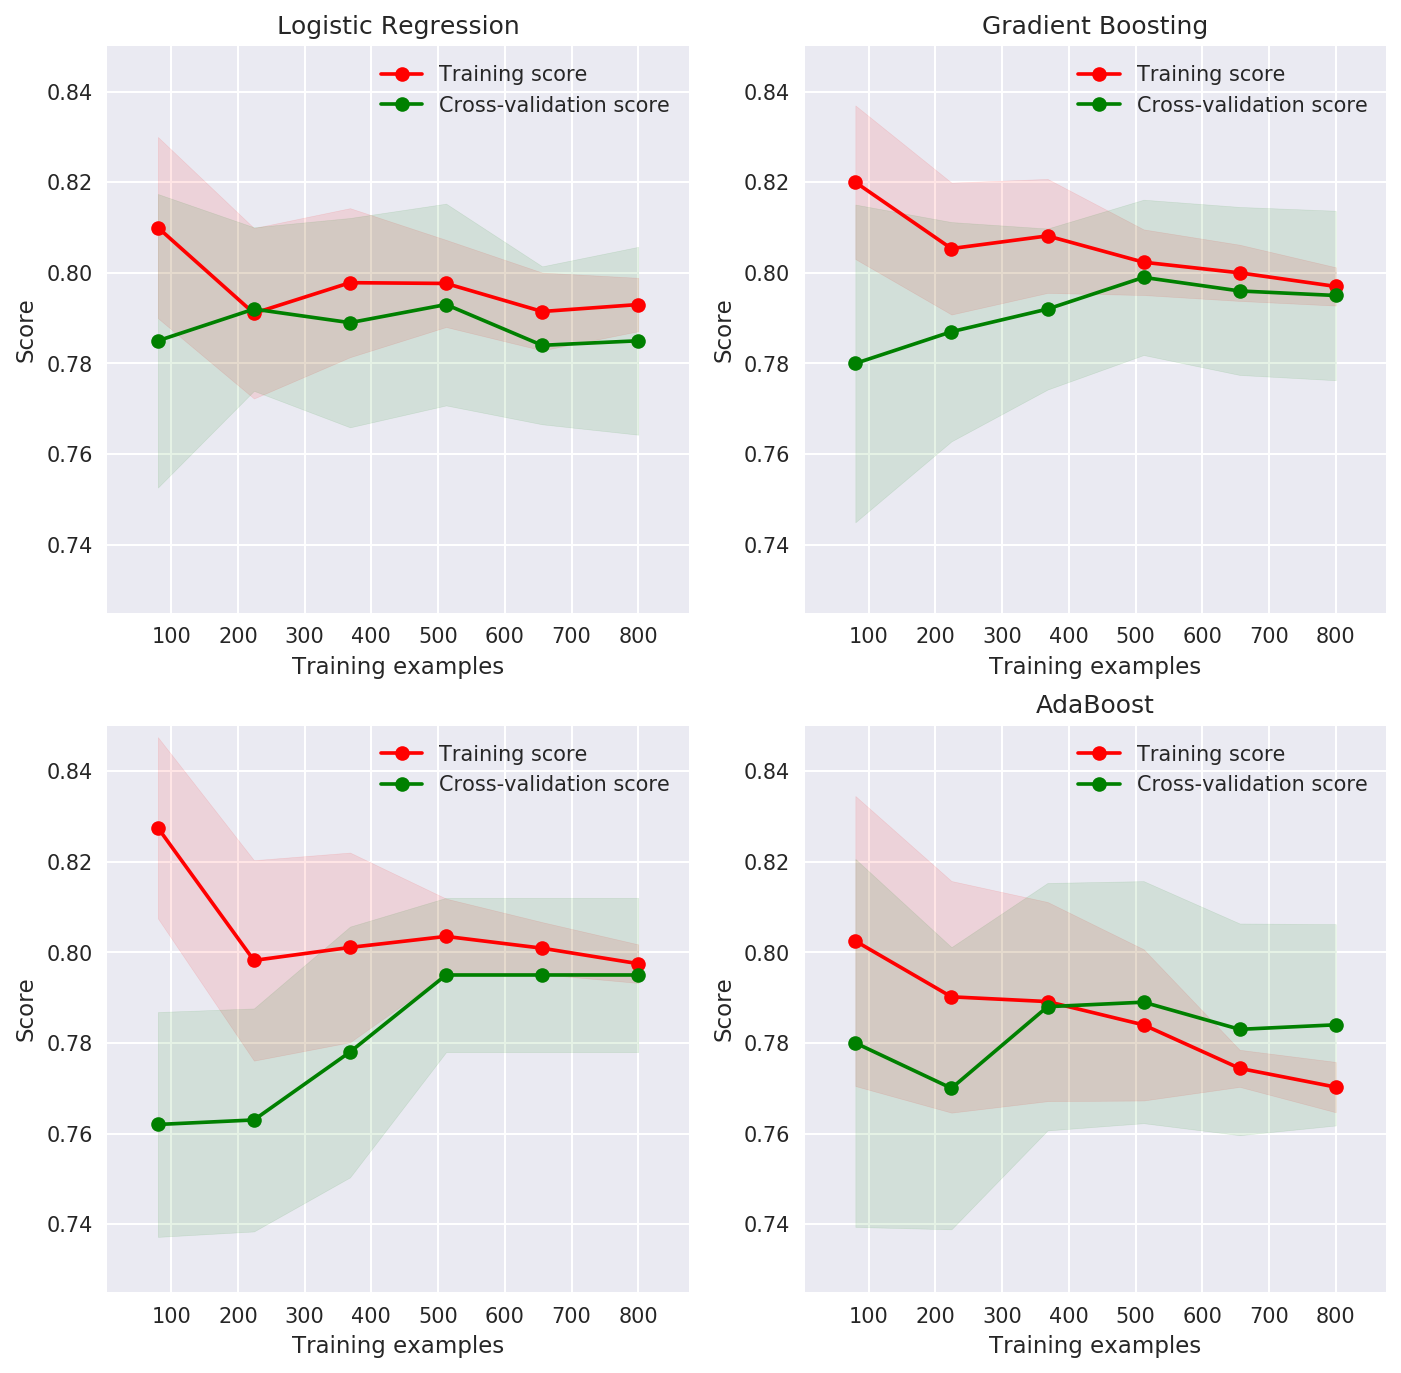

In [20]:
## load the data
y, X = load_data()

make_aavail_compare_plot(X, y)

### Feature Importance

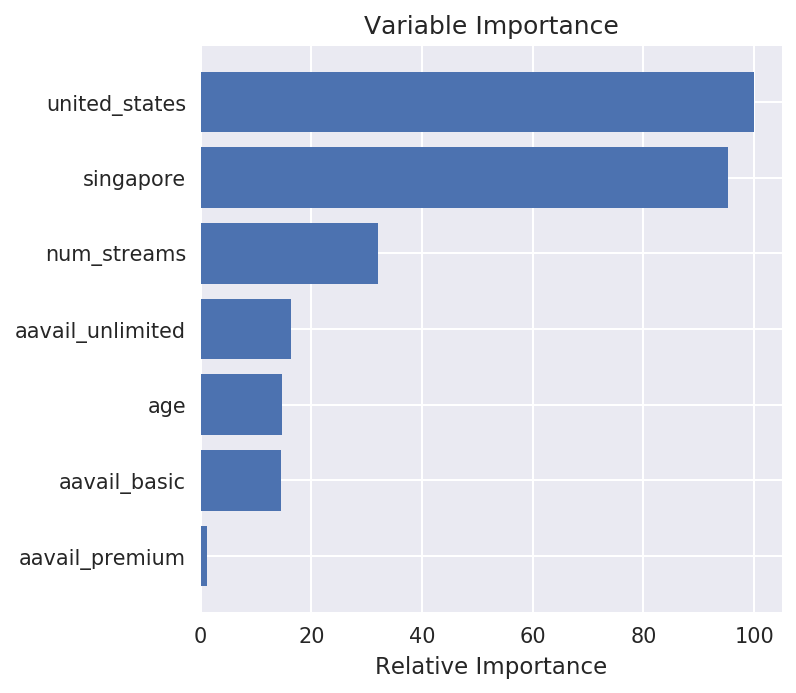

In [21]:
rs = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=rs)
params = {"n_estimators":100, "max_depth":2}
clf = RandomForestClassifier(**params)
pipe = Pipeline(steps=[("pre", preprocessor), ("clf", clf)])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
feature_names = np.hstack([numeric_features, 
                           preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names()])
feature_names = np.array([re.sub("x\d_","",fn) for fn in feature_names])
target_names = ['subscriber','churned']

def plot_feature_importance(clf):
    fig = plt.figure(figsize=(5, 5), dpi=150, facecolor="white")
    ax = fig.add_subplot(111)
    
    # make importances relative to max importance
    feature_importance = clf.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)[:25]
    pos = np.arange(sorted_idx.shape[0]) + .5
    
    ax.barh(pos, feature_importance[sorted_idx], align="center")
    plt.yticks(pos, feature_names[sorted_idx])
    ax.set_xlabel('Relative Importance')
    ax.set_title('Variable Importance')

plot_feature_importance(clf)